# A physically-based precipitation model

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve 
import matplotlib.pyplot as plt

## Clases y funciones

In [34]:
class precip_model:
    
    def __init__(self):
        
        self.cl =  953 # inverse mean diameter size at cloud base (m^-1)
        self.n0 = 8e6 # Particle size distribution parameter (m^-4)
        self.v = 3.0 # Updraft velocity (m s^-1)
        self.gamma = 5 # Ratio between inverse mean diameter at cloud's top and base level
        self.c1 = 7e5 # Critical diameter parameter (kg m^-3 s^-1)
        self.alpha = 1000 # Parameterization constant for terminal velocity (s^-1)
        self.zb = 420 # Elevation of cloud base (m)
        self.zc = 6000 # Initial cloud thickness (m)
        self.lapse_rate = 6.9 # Environment lapse rate (K km^-1)
        self.p0 = 1000 # Air pressure at soil level, z = 0m (mb)
        self.rho_w = 1000 # Standard water density (kg m^-3)
        self.beta = 1 # distribution parameter for updraft velocity
        
        self.A = 2.5e6 # Parameter for latent heat eq. (J kg^-1)
        self.B = 2.38e3 # Parameter for latent heat eq. (J kg^-1 K^-1)
        self.A1 = 8e-4 # Linearization parameter for Clausius-Clapeyron solution (kg m^-1 s^-2 K^-3.5)
        
        self.ret = []
                
    def temperature(self, T0, z, z0=0):
        '''
        Parameters
        ----------
        T0 : float
            Reference temperature (K)
        z : float
            Output elevation (m).
        z0 : float, optional
            Reference elevation (m). The default is 0.

        Returns
        -------
        T : float
            Temperature at z.
        '''
        
        lapse_rate = self.lapse_rate/1000
        T = T0 - lapse_rate*(z - z0)
        return T
    
    def sat_vap_pressure(self, T):
        '''
        Parameters
        ----------
        T : float
            Temperature (K).

        Returns
        -------
        e_sat : float
            Saturation vapor pressure for temperature T (Pa).
        '''
        
        A1 = self.A1
        e_sat = A1 * (T - 223.15) ** 3.5
        return e_sat
    
    def latent_heat(self, T):
        '''
        Parameters
        ----------
        T : float
            Water temperature (K)

        Returns
        -------
        lh : float
            Latent heat of evaporation/condensation (J kg^-1)
        '''
        
        A = self.A
        B = self.B
        lh = A - B * (T - 273.15)
        return lh
        
    def initial_mixing_ratio(self, Ts, T0, Te, cp = 1004):
        '''
        Parameters
        ----------
        Ts : float
            Condensation level temperature (K)
        T0 : float
            Potential temperature (K)
        Te : float
            Equivalent potential temperature (K)
        cp : float, optional
            Specific heat at constant pressure (J kg^-1 K^-1). The default is 1004.

        Returns
        -------
        w0 : float
            Mixing ratio at ground level (kg/kg)
        '''
        
        lh_s = self.latent_heat(Ts)
        w0 = cp * Ts * np.log(Te/T0)/lh_s        
        return w0
    
    def mixing_ratio(self, T, p):
        '''
        Parameters
        ----------
        T : float
            Temperature (K)
        p : float
            Pressure (Pa) 
            
        Returns
        -------
        w : float
            Mixing ratio (kg/kg).
        '''
 
        e = self.sat_vap_pressure(T)
        w = 0.622 * e/p
        return w   
    
    def wet_bulb_temperature(self, T0, w0, cp = 1004):
        '''
        Parameters
        ----------
        T0 : float
            Reference temperature (K)
        w0 : float
            Reference mixing ratio (kg/kg)
        cp : float, optional
            Specific heat at constant pressure (J kg^-1 K^-1). The default is 1004.

        Returns
        -------
        float
            Wet-bulb temperature (K)
        '''
        
        def T_wb(x, self, T0, w0, cp):
            p0 = self.p0
            ws = self.mixing_ratio(x, p0*100)
            lh_w = self.latent_heat(x)
            return (x - T0)/(w0 - ws) - lh_w/cp
        
        return fsolve(T_wb, x0 = T0, args=(self, T0, w0, cp))[0]
    
    def vapor_diffusivity(self, T0, T_ref = 273.15, p_ref = 1013.25):
        '''
        Parameters
        ----------
        T0 : float
            Temperature at the ground level (K).
        T_ref : float, optional
            Reference temperature (K). The default is 273.15.
        p_ref : float, optional
            Reference pressure (mb). The default is 1013.25.

        Returns
        -------
        D_vap : float
            Water vapor diffusivity (m^2 s^-1).
        '''
        p0 = self.p0
        D_vap = 2.11e-5*(T0/T_ref) ** 1.94 * (p_ref/p0)
        return D_vap
    
    def critical_diameter(self, T0, Te, Rd = 287, T_ref = 273.15, p_ref = 1013.25, cp = 1004):
        '''
        Parameters
        ----------
        T0 : float
            Potential temperature (K).
        Te : float
            Equivalent potential temperature (K).
        Rd : float, optional
            Ideal gas constant for dry air (J kg^-1 K^-1). The default is 287.
        T_ref : float, optional
            Reference temperature (K). The default is 273.15.
        p_ref : float, optional
            Reference pressure (mb). The default is 1013.25.
        cp : float, optional
            Specific heat at constant pressure (J kg^-1 K^-1). The default is 1004.

        Returns
        -------
        Dc : float
            Critical diameter such that smaller particles completely evaporate (m).
        '''
        
        p0 = self.p0 * 100
        c1 = self.c1
        zb = self.zb
                
        # Saturation vapor pressure with wet-bulb temperature
        Ts = self.temperature(T0, zb)
        w0 = self.initial_mixing_ratio(Ts, T0, Te, cp)        
        T_wb = self.wet_bulb_temperature(T0, w0, cp)
        e_wb = self.sat_vap_pressure(T_wb)
        
        e0 = w0 * p0 / 0.622        
        D_vap = self.vapor_diffusivity(T0, T_ref, p_ref)
        Dc = (1/c1 * 4*D_vap/(Rd/0.622) * (e_wb/T_wb - e0/T0) * zb) ** (1/3)
        
        return Dc
    
    def vapor_mass(self):
        '''
        Returns
        -------
        X : float
            Water mass in the cloud column (kg).
        '''
        
        rho_w = self.rho_w
        n0 = self.n0
        zc = self.zc
        cl = self.cl
        gamma = self.gamma
        
        delta = 1/3 * (1/gamma + 1/(gamma**2) + 1/(gamma**3))
        X = np.pi * rho_w * n0 * zc /(cl**4) * delta
        
        return X
    
    def mass_input(self, T0, Te, pt, dA = 1, cp = 1004, Rd = 287):
        '''
        Parameters
        ----------
        T0 : float
            Potential temperature (K).
        Te : float
            Equivalent potential temperature (K).
        pt : float
            Pressure at the cloud´s top level (mb).
        dA : float, optional
            area differential (m^2). The default is 1.
        cp : float, optional
            Specific heat at constant pressure (J kg^-1 K^-1). The default is 1004.
        Rd : float, optional
            Ideal gas constant for dry air (J kg^-1 K^-1). The default is 287.

        Returns
        -------
        dictionary
            Contains values for:
                Ts : Temperature at condensation level (cloud base) (K)
                ps : Pressure at condensation level (cloud base) (mb)
                Tt: Temperature at cloud´s top level (K)
                Td: dew point temperature at the ground level (K)
                w0: mixing ratio at the ground level (kg/kg)
                I: Condensation mass rate input to the cloud (kg s^-1)
        '''
               
        p0 = self.p0
        zb = self.zb
        v = self.v
        
        Ts = self.temperature(T0, zb)
        w0 = self.initial_mixing_ratio(Ts, T0, Te, cp)
        Td = T0 - 223.15*(T0/Ts - 1)
        ps = p0 / (((T0 - Td)/223.15 + 1) ** 3.5)
        
        def Tt_func(x, self, T0, Te, pt, pn, cp):
            lh_t = self.latent_heat(x)
            ws = self.mixing_ratio(x, pt*100)
            return Te/x - (pn/pt) ** 0.286 * np.exp(lh_t * ws / (cp * x))
        
        Tt = fsolve(Tt_func, x0 = Ts, args=(self, T0, Te, pt, p0, cp))[0]
        wt = self.mixing_ratio(Tt, pt*100)         
        
        dw = w0 - wt
                
        rho_t = pt / (Rd * Tt) * 100
        rho_b = ps / (Rd * Ts) * 100
        
        I = dw * (rho_b + rho_t)/2 * v * dA       
        
        return {'Ts': Ts, 'ps': ps, 'Tt': Tt, 'Td': Td, 'w0': w0, 'I': I}
    
    def mass_output(self, T0, Te, Rd = 287, T_ref = 273.15, p_ref = 1013.25, cp = 1004):
        '''
        Parameters
        ----------
        T0 : float
            Potential temperature (K).
        Te : float
            Equivalent potential temperature (K).
        Rd : float, optional
            Ideal gas constant for dry air (J kg^-1 K^-1). The default is 287.
        T_ref : float, optional
            Reference temperature (K). The default is 273.15.
        p_ref : float, optional
            Reference pressure (mb). The default is 1013.25.
        cp : float, optional
            Specific heat at constant pressure (J kg^-1 K^-1). The default is 1004.

        Returns
        -------
        dictionary
            Contains values for:
                X : Water mass in the cloud column (kg)
                Ot : Liquid water output rate at the cloud´s top level (kg s^-1)
                Ob: Liquid water output rate at the cloud's base level (kg s^-1)
                P: Precipitation intensity at the ground level (mm s^-1)
        '''
        beta = self.beta
        alpha = self.alpha
        v = self.v
        cl = self.cl
        gamma = self.gamma
        zc = self.zc
        
        Nv = beta * v * cl / alpha
        vp = 4 * alpha / cl
        
        Dc = self.critical_diameter(T0, Te, Rd, T_ref, p_ref, cp)
        Nd = cl * Dc
        
        X = self.vapor_mass()        
        delta = 1/3 * (1/gamma + 1/(gamma**2) + 1/(gamma**3))
        
        Ot = X/(delta*zc)*vp/(gamma**5)*((1/(np.exp(gamma*Nv)))*(1+3*gamma*Nv/4+((gamma*Nv)**2)/4+((gamma*Nv)**3)/24)+gamma*Nv/4-1)
        Ob = X/(delta*zc)*vp*((1/np.exp(Nv))*(1+3*Nv/4+(Nv**2)/4+(Nv**3)/24))
        
        if Nd >= Nv:
            P = X/(delta*zc)*vp*(1/np.exp(Nd))*((1-Nv/4)*(1+Nd+(Nd**2)/2)+(Nd**3)/8)
        else:
            P = X/(delta*zc)*vp*(1/np.exp(Nv))*(1+3/4*Nv+(Nv/2)**2+(Nv**3)/24-(Nd**3)/24)
        
        return {'X': X, 'Ot': Ot, 'Ob': Ob, 'P': P}
    
    def update_zc(self, dX):
        '''
        Parameters
        ----------
        dX : float
            Change in water mass in cloud column (kg).

        Returns
        -------
        None.
        '''
        
        rho_w = self.rho_w
        n0 = self.n0
        cl = self.cl
        gamma = self.gamma        

        X = self.vapor_mass()
        
        delta = 1/3 * (1/gamma + 1/(gamma**2) + 1/(gamma**3))
        zc_new = (X + dX) * (cl**4) / (np.pi * rho_w * n0 * delta)
        
        self.zc = zc_new
    
    def solve(self, filename_metdata):
        '''
        Parameters
        ----------
        filename_metdata : str
            Path to .csv file with meteorological data for storms.

        Returns
        -------
        ret : Pandas DataFrame
            Contains:
                t: time (s)
                Te: Equivalent potential temperature (K)
                T0: Potential temperature (K)
                pt: Pressure at the cloud´s top level (mb)
                Ts : Temperature at condensation level (cloud base) (K)
                ps : Pressure at condensation level (cloud base) (mb)
                Tt: Temperature at cloud´s top level (K)
                Td: dew point temperature at the ground level (K)
                w0: mixing ratio at the ground level (kg/kg)
                I: Condensation mass rate input to the cloud (kg s^-1)
                X : Water mass in the cloud column (kg)
                Ot : Liquid water output rate at the cloud´s top level (kg s^-1)
                Ob: Liquid water output rate at the cloud's base level (kg s^-1)
                P: Precipitation intensity at the ground level (mm s^-1)

        '''
        met_data = np.loadtxt(filename_metdata, delimiter=',')
        
        t, Te, T0, pt = met_data
        Ts = ps = Tt = Td = w0 = I = []
        X = Ot = Ob = P = []
        for i, [t_i, Te_i, T0_i, pt_i] in enumerate(zip(t, Te, T0, pt)):    
            
            Ts_i, ps_i, Tt_i, Td_i, w0_i, I_i = model.mass_input(T0_i, Te_i, pt_i).values()
            X_i, Ot_i, Ob_i, P_i = model.mass_output(T0_i, Te_i).values()
            
            if i < (len(t)-1):
                dX_i = (I_i - Ot_i - Ob_i) * (t[i+1] - t_i)
                model.update_zc(dX_i)
                
            Ts = Ts + [Ts_i]
            ps = ps + [ps_i]
            Tt = Tt + [Tt_i]
            Td = Td + [Td_i]
            w0 = w0 + [w0_i]
            I = I + [I_i]
            X = X + [X_i]
            Ot = Ot + [Ot_i]
            Ob = Ob + [Ob_i]
            P = P + [P_i]
            
        ret = pd.DataFrame({'t':t, 'Te':Te, 'T0':T0, 'pt': pt, 
               'Ts':Ts, 'ps': ps, 'Tt': Tt, 'Td': Td, 'w0': w0,
               'X':X, 'I': I, 'Ot': Ot, 'Ob': Ob, 'P': P})
        
        self.ret = ret        
        return ret
    
    def get_Ptotal(self):
        '''
        Returns
        -------
        Pt : float
            Total precipitation for input storms (mm).
        '''
        
        output = self.ret

        t = np.array(output['t'])
        P = np.array(output['P'])
        X = np.array(output['X'])
        
        t_step = 1
        t_int = np.arange(t[0],t[-1] + t_step, t_step)
        X_int = np.interp(t_int, t, X)
        P_int = np.interp(t_int, t, P)
        
        P_int[X_int < 0] = 0
        X_int[X_int < 0] = 0
        
        P = P_int
        dt = np.diff(t_int)
        
        Pavg = [(P[i] + P[i+1])/2 for i,_  in enumerate(P) if i < (len(P) - 1)]
        Pt = sum(Pavg * dt)
        
        t_end = min(t_int[X_int == 0])

        print(f'The storm ends after {t_end:3.0f} s')
        print(f'The total storm precipitation is {Pt:3.2f} mm')
        
        return [Pt, t_int, P_int]

## Programa principal

In [39]:
file = 'met_data.csv'
    
# Create model object
model = precip_model()
# Run solver
output = model.solve(file)
# Report total precip.
Pt, t, P = model.get_Ptotal()

The storm ends after 1121 s
The total storm precipitation is 50.60 mm


### Gráficas

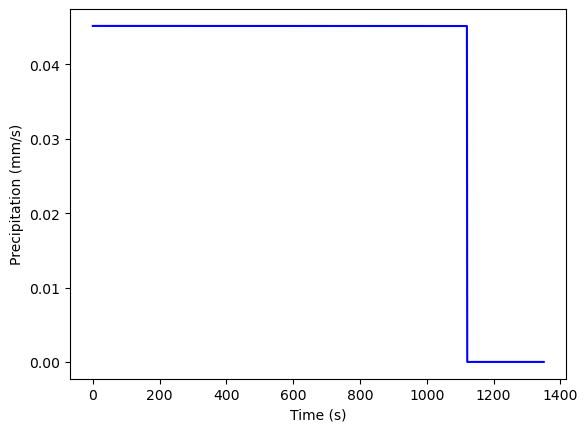

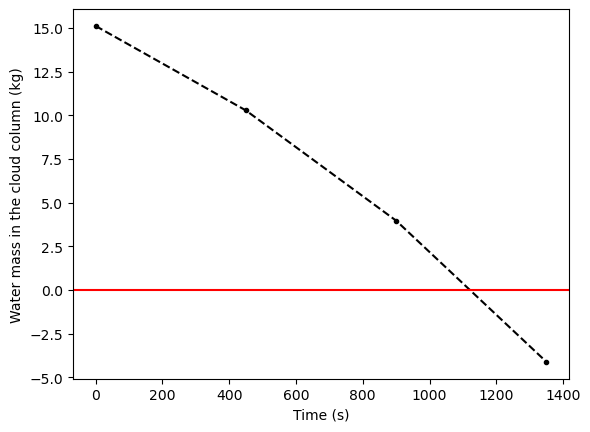

In [41]:
# Precip
plt.plot(t, P,'b-')
plt.ylabel('Precipitation (mm/s)')
plt.xlabel('Time (s)')
plt.show()

# Water mass in the cloud column
plt.plot(output['t'], output['X'],'k.--')
plt.axhline(y=0.0, color='r', linestyle='-')
plt.ylabel('Water mass in the cloud column (kg)')
plt.xlabel('Time (s)')
plt.show()